In [ ]:
# 필요패키지 import
import time
import json
import urllib
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# #코랩 한글깨짐 방지 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# 파일 불러오기

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# # merge

# event = pd.read_csv('/content/gdrive/MyDrive/Final Project/sampled_events.csv')
# product = pd.read_csv('/content/gdrive/MyDrive/Final Project/sampled_products.csv')
# user = pd.read_csv('/content/gdrive/MyDrive/Final Project/sampled_users.csv')

# event_product = event.merge(product, on='item_no', how='left')
# commerce = event_product.merge(user, on='user_no', how='left')

commerce = pd.read_csv('/content/gdrive/MyDrive/Final Project/data/commerce.csv')
final = pd.read_csv('/content/gdrive/MyDrive/Final Project/real_real_final_user.csv')

## 테이블 만들기

In [ ]:
total = commerce.copy()

In [ ]:
# 출생년도
total['birth_date'] = pd.to_datetime(total['birth_date'], errors = 'coerce')

# 나이 계산
total['age'] = 2021 - total['birth_date'].dt.year

# 나이대
total['나이대'] = np.where(total['age'] < 10, '0-9세', 
                        np.where(total['age'] < 20, '10대',
                        np.where(total['age'] < 30, '20대',
                        np.where(total['age'] < 40, '30대',
                        np.where(total['age'] < 50, '40대',
                        np.where(total['age'] < 60, '50대',
                        np.where(total['age'] < 70, '60대', 
                        np.where(total['age'] < 80, '70대',
                        np.where(total['age'] < 90, '80대','90대')))))))))

In [ ]:
# event timestamp => datetime
total['event_timestamp'] = pd.to_datetime(total['event_timestamp'], errors = 'coerce')

# event_year은 모두 2021년이라 삭제

total['event_month'] = total['event_timestamp'].dt.month
total['event_day'] = total['event_timestamp'].dt.day
total['event_weekday'] = total['event_timestamp'].dt.dayofweek
total['event_hour'] = total['event_timestamp'].dt.hour
total['event_minute'] = total['event_timestamp'].dt.minute
total['event_timestamp'] = total['event_timestamp'].dt.date

In [ ]:
total['event_timestamp'] = pd.to_datetime(total['event_timestamp'])

# 날짜 기준 (6.6 ~ 7.31)
total = total[(total['event_timestamp'] >= '2021-06-06') & (total['event_timestamp'] <= '2021-07-31')]

In [ ]:
# 구매자 리스트 (중복 없음)
buyer_list = total[total['event_name'] == 'purchase_success'].drop_duplicates(['user_no'], keep='first')

# 구매자이면 1, 아니면 NaN
buyer_list['buyer'] = 1

buyer_list = buyer_list[['user_no','buyer']]

In [ ]:
# 구매자, 비구매자 구분 : 'buyer' 구매자 1, 비구매자 0
total = total.merge(buyer_list, on='user_no', how='left')

total['buyer'].fillna(0, inplace=True)

In [ ]:
total.drop(['mobile_model_name','mobile_marketing_name','operating_system_version','image_name','category1_code','category2_code','category3_code','brand_no','event_minute','age','birth_date'], axis=1, inplace=True)

In [ ]:
total.head(3)

,session_id,event_timestamp,event_name,user_no,item_no,device_type,mobile_brand_name,country,region,platform,item_name,price,category1_name,category2_name,category3_name,brand_name,gender,나이대,event_month,event_day,event_weekday,event_hour,buyer
0,5240d1b731949382c749c79db207b2fa,2021-06-06,click_item,j2PG6ak1chv+aTkyNM3JzA==,JdwoJ4a/Z2YK5nKCKWUiyw==,mobile,Apple,South Korea,Seoul,IOS,WOOL SILK CROP JACKET - SEAL BROWN,135000.0,의류,아우터,재킷,MORE OR LESS,F,20대,6,6,6,0,0.0
1,5ae2c24c1c3e9dc228846c772cfbbbdc,2021-06-06,click_item,tBR8q7ZrRkJwO88bCX6aKA==,V9vAu4jSKMu64NY9zU155Q==,mobile,Apple,South Korea,Seoul,IOS,cl half pants (bone),117000.0,의류,하의,바지,MOIA,F,20대,6,6,6,0,1.0
2,a26a03a8f61bd3c476799f19ab57b22f,2021-06-06,purchase_success,qtcoyasZW4XF7NpbcSB4mg==,BWQ0HfKAo3/K7EMrMTcVxQ==,mobile,Apple,South Korea,Seoul,IOS,S S/S T-SHIRT,38000.0,의류,상의,티셔츠,NEITHERS,F,30대,6,6,6,0,1.0


### power_user & non_power_user

In [ ]:
total[total['buyer'] == 1]['user_no'].nunique()

138279

In [ ]:
# 구매자 나누기
user = total[(total['buyer'] == 1) & (total['event_name'] == 'purchase_success')]

# 구매자 기준 구매 상품 개수 
user_no = user.groupby(['user_no'])['item_no'].count().reset_index().sort_values('item_no', ascending=False)
user_no['user_cnt'] = 1

# 구매자 기준 구매 금액 랭킹
user_price = user.groupby(['user_no'])['price'].sum().reset_index().sort_values('price', ascending=False)

user_total = user_no.merge(user_price, on='user_no', how='left')

In [ ]:
user_total

,user_no,item_no,user_cnt,price
0,b2xZVfUtjyGsZckO7j6zkg==,246,1,28841100.0
1,anAN3a+fvEnnvFdQ61+Egw==,203,1,22966700.0
2,QYfrbtFOWrk6s0kyW/HAtQ==,147,1,7460990.0
3,S5rrjhjiYmOBfYlCTCitoQ==,132,1,4339200.0
4,NNQiP/5+hZPlrcm/raV6gg==,122,1,6151500.0
...,...,...,...,...
138274,aM5VoeFsjA3VA5AxMeU7RQ==,1,1,43800.0
138275,aM88zqdjmbbMMK1oqMSXGA==,1,1,65000.0
138276,aM9Aqlfo/zYtlb0HwNgIhA==,1,1,49900.0
138277,aMF2JdUJeWDBX3cwHPXMVA==,1,1,26000.0


In [ ]:
# power_user 기준 정하기 
user_vip = user_total[(( user_total['item_no'] >= 3 ) & ((user_total['price'] / user_total['item_no']) >= 10000))| ( user_total['price'] >= 166000 )]

user_vip = user_vip.sort_values(['price','item_no'], ascending=False)
user_total = user_vip.append(user_total)

user_total = user_total.drop_duplicates('user_no', keep='first')
user_normal = user_total[59526:]
user_normal = user_normal.sort_values(['price','item_no'], ascending=False)

user_total = user_vip.append(user_normal)

In [ ]:
# power_user 기준 정하기 
user_vip = user_total[(( user_total['item_no'] >= 3 ) & ((user_total['price'] / user_total['item_no']) >= 10000))| ( user_total['price'] >= 166000 )]

In [ ]:
# 비구매자 user_no
unbuyer = total[(total['buyer'] == 0)]

unbuyer = unbuyer.groupby(['user_no'])['item_no'].count().reset_index()
unbuyer['item_no'] = 0
unbuyer['user_cnt'] = 1
unbuyer['price'] = 0

user_total = user_total.append(unbuyer)

In [ ]:
# 유저 수 누적 비율
user_total['user_cnt_cum'] =  user_total['user_cnt'].cumsum()
user_total['user_per_percent'] = user_total['user_cnt'] / len(user_total) * 100
user_total['user_per_percent_cum'] = user_total['user_per_percent'].cumsum()

# 유저 구매 금액 누적 비율
user_total['price_cum'] = user_total['price'].cumsum()
user_total['price_per_percent'] = user_total['price'] / sum(user_total['price']) * 100
user_total['price_per_percent_cum'] = user_total['price_per_percent'].cumsum()

# 유저 구매 상품 개수 누적 비율
user_total['item_no_cum'] = user_total['item_no'].cumsum()
user_total['item_per_percent'] = user_total['item_no'] / sum(user_total['item_no']) * 100
user_total['item_per_percent_cum'] = user_total['item_per_percent'].cumsum()

# 필요없는 컬럼 삭제
user_total = user_total.drop(['user_cnt','item_per_percent','user_cnt_cum','user_per_percent','item_no_cum','price_cum','price_per_percent'], axis=1)

In [ ]:
# 전체 유저 순서 정렬
user_total.reset_index(drop=True, inplace=True)

# 파워 유저 & 논 파워 유저(only 구매자)
user_vip = user_total[:59525]
user_normal = user_total[59526:]

In [ ]:
# 파워 유저 & 논 파워 유저(구매자 & 비구매자 포함)
user_vip['power_user'] = 1

user_total = user_total.merge(user_vip, on=['user_no', 'item_no', 'price', 'user_per_percent_cum',
       'price_per_percent_cum', 'item_per_percent_cum'], how='left')

user_total['power_user'].fillna(0, inplace=True)
user_cum = user_total.drop(['user_per_percent_cum','price_per_percent_cum','item_per_percent_cum'], axis=1)

user_cum.columns = ['user_no','item_per_cnt','total_per_price','power_user']

In [ ]:
user_total

,user_no,item_no,price,user_per_percent_cum,price_per_percent_cum,item_per_percent_cum,power_user
0,b2xZVfUtjyGsZckO7j6zkg==,246,28841100.0,0.00041,0.113023,0.057963,1.0
1,anAN3a+fvEnnvFdQ61+Egw==,203,22966700.0,0.00082,0.203026,0.105794,1.0
2,pywOPeCTmJKudBVHC1/5iw==,15,11035900.0,0.00123,0.246274,0.109328,1.0
3,8j/l4DjsSqXcIR9r5GAmLQ==,115,10068900.0,0.00164,0.285732,0.136425,1.0
4,tCbVorRR1nnG7W2rSzxZNQ==,3,10008000.0,0.00205,0.324952,0.137132,1.0
...,...,...,...,...,...,...,...
243866,zzrlop3HrqxAgIT0VJ9wRg==,0,0.0,99.99836,100.000000,100.000000,0.0
243867,zzwOfX9q6MNyni9Ff8Ws6A==,0,0.0,99.99877,100.000000,100.000000,0.0
243868,zzwQnhNQeYnzcsjywnIh3g==,0,0.0,99.99918,100.000000,100.000000,0.0
243869,zzxlG1wzPCGvsW0SlOleDg==,0,0.0,99.99959,100.000000,100.000000,0.0


In [ ]:
user_vip

,user_no,item_no,price,user_per_percent_cum,price_per_percent_cum,item_per_percent_cum,power_user
0,b2xZVfUtjyGsZckO7j6zkg==,246,28841100.0,0.000410,0.113023,0.057963,1
1,anAN3a+fvEnnvFdQ61+Egw==,203,22966700.0,0.000820,0.203026,0.105794,1
2,pywOPeCTmJKudBVHC1/5iw==,15,11035900.0,0.001230,0.246274,0.109328,1
3,8j/l4DjsSqXcIR9r5GAmLQ==,115,10068900.0,0.001640,0.285732,0.136425,1
4,tCbVorRR1nnG7W2rSzxZNQ==,3,10008000.0,0.002050,0.324952,0.137132,1
...,...,...,...,...,...,...,...
59520,DyasvMcma5FbF2AHHu+ubw==,3,30000.0,24.406756,80.056973,74.639146,1
59521,2y/T4u1hI1U5+ww0mqLdnA==,3,30000.0,24.407166,80.057091,74.639853,1
59522,I56mmeC+DT7GueHwbOVeow==,3,30000.0,24.407576,80.057208,74.640560,1
59523,7/PpFKdDqzuxcluFxAryyQ==,3,30000.0,24.407986,80.057326,74.641267,1


In [ ]:
# # merge
# final_user = total.merge(user_cum, on='user_no', how='left')

# # week 만들기
# final_user['week'] = np.where(final_user['event_timestamp'] <= '2021-06-12', 1, 
#                         np.where(final_user['event_timestamp'] <= '2021-06-19', 2,
#                         np.where(final_user['event_timestamp'] <= '2021-06-26', 3,
#                         np.where(final_user['event_timestamp'] <= '2021-07-03', 4,
#                         np.where(final_user['event_timestamp'] <= '2021-07-10', 5,
#                         np.where(final_user['event_timestamp'] <= '2021-07-17', 6,
#                         np.where(final_user['event_timestamp'] <= '2021-07-24', 7, 8)))))))

In [ ]:
# # 데이터 추출
# final_user.to_csv('/content/gdrive/MyDrive/Final Project/real_real_real_final_user.csv', index=False)

# 파워 유저 & 논 파워 유저

## 전체 대비 비교

In [ ]:
user_total

,user_no,item_no,price,user_per_percent_cum,price_per_percent_cum,item_per_percent_cum,power_user
0,b2xZVfUtjyGsZckO7j6zkg==,246,28841100.0,0.00041,0.113023,0.057963,1.0
1,anAN3a+fvEnnvFdQ61+Egw==,203,22966700.0,0.00082,0.203026,0.105794,1.0
2,pywOPeCTmJKudBVHC1/5iw==,15,11035900.0,0.00123,0.246274,0.109328,1.0
3,8j/l4DjsSqXcIR9r5GAmLQ==,115,10068900.0,0.00164,0.285732,0.136425,1.0
4,tCbVorRR1nnG7W2rSzxZNQ==,3,10008000.0,0.00205,0.324952,0.137132,1.0
...,...,...,...,...,...,...,...
243866,zzrlop3HrqxAgIT0VJ9wRg==,0,0.0,99.99836,100.000000,100.000000,0.0
243867,zzwOfX9q6MNyni9Ff8Ws6A==,0,0.0,99.99877,100.000000,100.000000,0.0
243868,zzwQnhNQeYnzcsjywnIh3g==,0,0.0,99.99918,100.000000,100.000000,0.0
243869,zzxlG1wzPCGvsW0SlOleDg==,0,0.0,99.99959,100.000000,100.000000,0.0


## 다른 데이터와의 혼합

In [ ]:
# 날짜 기준 (6.6 ~ 7.31)
final = final[(final['event_timestamp'] >= '2021-06-06') & (final['event_timestamp'] <= '2021-07-31')]

In [ ]:
final.head(2)

,session_id,event_timestamp,event_name,user_no,item_no,device_type,mobile_brand_name,country,region,platform,item_name,price,category1_name,category2_name,category3_name,brand_name,birth_date,gender,나이대,event_month,event_day,event_weekday,event_hour,buyer,item_per_cnt,total_per_price,power_user,week
0,5240d1b731949382c749c79db207b2fa,2021-06-06,click_item,j2PG6ak1chv+aTkyNM3JzA==,JdwoJ4a/Z2YK5nKCKWUiyw==,mobile,Apple,South Korea,Seoul,IOS,WOOL SILK CROP JACKET - SEAL BROWN,135000.0,의류,아우터,재킷,MORE OR LESS,1995-07-07,F,20대,6,6,6,0,0.0,0.0,0.0,0.0,1
1,5ae2c24c1c3e9dc228846c772cfbbbdc,2021-06-06,click_item,tBR8q7ZrRkJwO88bCX6aKA==,V9vAu4jSKMu64NY9zU155Q==,mobile,Apple,South Korea,Seoul,IOS,cl half pants (bone),117000.0,의류,하의,바지,MOIA,1993-02-11,F,20대,6,6,6,0,1.0,1.0,128000.0,0.0,1


In [ ]:
# 각 유저 별 총 클릭 횟수
click_cnt_power = final[(final['power_user'] == 1) & (final['event_name'] == 'click_item')].groupby(['user_no'])['item_no'].count().reset_index().rename(columns = {'item_no' : 'click_cnt'})
click_cnt_non_power = final[(final['power_user'] == 0) & (final['event_name'] == 'click_item')].groupby(['user_no'])['item_no'].count().reset_index().rename(columns = {'item_no' : 'click_cnt'})

# 각 유저 별 총 장바구니 횟수
cart_cnt_power = final[(final['power_user'] == 1) & (final['event_name'] == 'add_to_cart')].groupby(['user_no'])['item_no'].count().reset_index().rename(columns = {'item_no' : 'cart_cnt'})
cart_cnt_non_power = final[(final['power_user'] == 0) & (final['event_name'] == 'add_to_cart')].groupby(['user_no'])['item_no'].count().reset_index().rename(columns = {'item_no' : 'cart_cnt'})

# 각 유저 별 총 좋아요 횟수
like_cnt_power = final[(final['power_user'] == 1) & (final['event_name'] == 'like_item')].groupby(['user_no'])['item_no'].count().reset_index().rename(columns = {'item_no' : 'like_cnt'})
like_cnt_non_power = final[(final['power_user'] == 0) & (final['event_name'] == 'like_item')].groupby(['user_no'])['item_no'].count().reset_index().rename(columns = {'item_no' : 'like_cnt'})

In [ ]:
# 각 행동 패턴, 각 유저 행동 횟수
click_cnt = click_cnt_power.append(click_cnt_non_power)
cart_cnt = cart_cnt_power.append(cart_cnt_non_power)
like_cnt = like_cnt_power.append(like_cnt_non_power)

In [ ]:
# 행동 패턴 테이블 합치기
user_total = user_total.merge(click_cnt, on='user_no', how='left')
user_total = user_total.merge(cart_cnt, on='user_no', how='left')
user_total = user_total.merge(like_cnt, on='user_no', how='left')

In [ ]:
# 행동 패턴 결측치 정리
user_total.fillna(0, inplace=True)
user_total.isnull().sum().sum()

0

In [ ]:
# 기타 인적 사항 테이블 만들기
user_info = final[['user_no','buyer','mobile_brand_name','region','platform','gender','나이대']]
user_info.drop_duplicates('user_no', keep='first', inplace=True)
# user_total = user_total.merge(user_info, on='user_no', how='left')

In [ ]:
user_total = user_total.merge(user_info, on='user_no', how='left')

In [ ]:
# 전체 유저no
all_user_no = final[['user_no']]

# 의류 구매자 테이블
clothes_cnt = final[(final['category1_name'] == '의류') & (final['event_name'] == 'purchase_success')].groupby(['user_no'])['item_no'].count().reset_index().rename(columns={'item_no' : '의류'})

# 전체 유저no & 의류 구매자 테이블 합치기
category_p_cnt = all_user_no.merge(clothes_cnt,on='user_no', how='left')

In [ ]:
# 각 유저 카테고리 별 구매 개수 테이블
for category in final['category1_name'].unique()[1:-5]:
    category_cnt =  final[(final['category1_name'] == category) & (final['event_name'] == 'purchase_success')].groupby(['user_no'])['item_no'].count().reset_index().rename(columns={'item_no' : category})
    category_p_cnt = category_p_cnt.merge(category_cnt, on='user_no', how='left')

# 비구매자 결측치 0으로 대체
category_p_cnt.fillna(0, inplace=True)
# 중복 유저 no 제거
category_p_cnt.drop_duplicates('user_no', keep='first', inplace=True)

In [ ]:
# user_total과 카테고리 별 구매 개수 테이블 합치기

user_total = user_total.merge(category_p_cnt, on='user_no', how='left')

In [ ]:
# 전체 유저no
all_user_no = final[['user_no']]

# 일요일 구매자 테이블
sunday_cnt = final[(final['event_weekday'] == 6) & (final['event_name'] == 'purchase_success')].groupby(['user_no'])['item_no'].count().reset_index().rename(columns={'item_no' : '일요일'})

# 전체 유저no & 의류 구매자 테이블 합치기
week_p_cnt = all_user_no.merge(sunday_cnt,on='user_no', how='left')

In [ ]:
# 각 유저 요일 별 구매 개수 테이블
for week in final['event_weekday'].unique()[1:]:
    week_cnt =  final[(final['event_weekday'] == week) & (final['event_name'] == 'purchase_success')].groupby(['user_no'])['item_no'].count().reset_index().rename(columns={'item_no' : week})
    week_p_cnt = week_p_cnt.merge(week_cnt, on='user_no', how='left')

# 비구매자 결측치 0으로 대체
week_p_cnt.fillna(0, inplace=True)
# 중복 유저 no 제거
week_p_cnt.drop_duplicates('user_no', keep='first', inplace=True)
# 요일 이름 바꾸기
week_p_cnt.columns = ['user_no','일요일','월요일','화요일','수요일','목요일','금요일','토요일']

In [ ]:
# user_total과 요일 별 구매 개수 테이블 합치기

user_total = user_total.merge(week_p_cnt, on='user_no', how='left')

In [ ]:
user_total['item_per_price'] = user_total['price'] / user_total['item_no'] 

In [ ]:
user_total['item_per_price'].fillna(0, inplace=True)

In [ ]:
user_total.rename(columns = {'item_no' : 'buy_cnt'}, inplace=True)

## 각 user 특성에 따른 종합적인 분석

In [ ]:
user_total.head(2)

,user_no,buy_cnt,price,user_per_percent_cum,price_per_percent_cum,item_per_percent_cum,power_user,click_cnt,cart_cnt,like_cnt,buyer,mobile_brand_name,region,platform,gender,나이대,의류,생활/건강,스포츠/레저,잡화,화장품/미용,가구/인테리어,컬처,디지털/가전,식품,키즈,반려동물,성년의날,일요일,월요일,화요일,수요일,목요일,금요일,토요일,item_per_price
0,b2xZVfUtjyGsZckO7j6zkg==,246,28841100.0,0.00041,0.113023,0.057963,1.0,7534.0,0.0,0.0,1.0,Apple,Chungcheongnam-do,IOS,F,40대,238.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,23.0,42.0,31.0,37.0,34.0,50.0,117240.243902
1,anAN3a+fvEnnvFdQ61+Egw==,203,22966700.0,0.00082,0.203026,0.105794,1.0,325.0,105.0,0.0,1.0,Samsung,Seoul,ANDROID,F,40대,171.0,9.0,2.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190.0,0.0,0.0,13.0,113136.453202


### 행동패턴

In [ ]:
action = user_total.pivot_table(index = ['power_user'], values = ['buy_cnt','click_cnt','cart_cnt','like_cnt','price','item_per_price'] ,aggfunc='mean')
action = action[['click_cnt','cart_cnt','like_cnt','buy_cnt','price','item_per_price']]
action

,click_cnt,cart_cnt,like_cnt,buy_cnt,price,item_per_price
power_user,,,,,,
0.0,11.015937,0.632761,0.531360,0.583804,27605.162949,21967.888553
1.0,38.934717,3.399210,1.618547,5.321932,343198.600689,82557.920530


- 파워유저 vs 논파워유저
- 클릭수: **약 3배**
- 장바구니: **약 5배**
- 좋아요: **약 3배**
- 구매수: **약 10배**
- 총구매금액: **약 12배**
- 상품별금액: **약 4배**


- 파워유저가 논파워유저보다 두드러지게 많이 행동하며, 그 중 파워유저는 논파워 구매자보다 장바구니를 5 배 많이사용한다.

- 논파워유저는 일인당 구매액 뿐만 아니라 구매하는 상품의 평균 가격이 파워유저의 비해 현저히 작다.(파워유저의 일인당 총 구매액 약 8%, 상품별 금액 약 26% 정도만 미친다.) 
        

In [ ]:
action = user_total.pivot_table(index = ['power_user','buyer'], values = ['buy_cnt','click_cnt','cart_cnt','like_cnt','price','item_per_price'] ,aggfunc='mean')
action = action[['click_cnt','cart_cnt','like_cnt','buy_cnt','price','item_per_price']]
action

click_cnt  cart_cnt  like_cnt   buy_cnt          price  \
power_user buyer                                                           
0.0        0.0    12.214424  0.626263  0.608007  0.000000       0.000000   
           1.0     9.533419  0.640799  0.436547  1.305965   61752.516370   
1.0        1.0    38.934717  3.399210  1.618547  5.321932  343198.600689   

                  item_per_price  
power_user buyer                  
0.0        0.0          0.000000  
           1.0      49141.981158  
1.0        1.0      82557.920530

**파워유저 vs 논파워유저(구매자) vs 논파워유저(비구매자)**
**논파워**
- 논파워 비구매자는 논파워 구매자의 비해 대체적으로 클릭등 행동을 많이 하는 편이지만 구매를 하지 않는다.
(action plan) 비구매자의 구매를 이끄는 방법 생각 : 특징 클릭을 많이한다.클릭과 연결한 쿠폰 발급

- 논파워 유져 중 구매자는 평균적으로 1개의 제품을 구매하며, 인당 62000원을 소비 (파워 유저의 총 사용액에 약 1/5(17%), 상품별 금액 59% 에 달한다.) 

=> 논파워 유져의 구매를 이끌때 비싼 제품보다는 현재 있는 제품의 갯수를 늘리는 쪽으로 으로 프로모션. why? 논 파워 유저들 제품당 소비하는 금액이 낮음.   


In [ ]:
week_day = user_total.pivot_table(index = ['power_user'], values = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일'] ,aggfunc='mean')
week_day = week_day[['월요일','화요일','수요일','목요일','금요일','토요일','일요일']]
week_day

,월요일,화요일,수요일,목요일,금요일,토요일,일요일
power_user,,,,,,,
0.0,0.088822,0.095077,0.085171,0.091355,0.073286,0.066104,0.083989
1.0,0.803494,0.842436,0.843007,0.777371,0.632692,0.608013,0.814918


**요일별**
(공통)
power_user  화요일 수요일에 구매가 가장 많이 일어난다.  금/토가 구매가 적다.
non_power_user 월요일 화요일에 구매가 가장 많이 일어난다. 금/토가 구매가 적다. 
(action plan) 수에 프로모션 
=> 배달이 주말이 오기 때문에 이때 사는 사람이 있다. 

In [ ]:

week_day = user_total.pivot_table(index = ['power_user','buyer'], values = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일'] ,aggfunc='mean')
week_day = week_day[['월요일','화요일','수요일','목요일','금요일','토요일','일요일']]
week_day

월요일       화요일       수요일       목요일       금요일       토요일  \
power_user buyer                                                               
0.0        0.0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           1.0    0.198694  0.212686  0.190528  0.204361  0.163940  0.147874   
1.0        1.0    0.803494  0.842436  0.843007  0.777371  0.632692  0.608013   

                       일요일  
power_user buyer            
0.0        0.0    0.000000  
           1.0    0.187882  
1.0        1.0    0.814918

In [ ]:
#2
category = user_total.pivot_table(index = ['power_user'], values = ['의류', '생활/건강', '스포츠/레저', '잡화',
       '화장품/미용', '가구/인테리어', '컬처', '디지털/가전', '식품', '키즈', '반려동물', '성년의날'] ,aggfunc='mean')
category = category[['의류', '생활/건강', '스포츠/레저', '잡화',
       '화장품/미용', '가구/인테리어', '컬처', '디지털/가전', '식품', '키즈', '반려동물', '성년의날']]
category

,의류,생활/건강,스포츠/레저,잡화,화장품/미용,가구/인테리어,컬처,디지털/가전,식품,키즈,반려동물,성년의날
power_user,,,,,,,,,,,,
0.0,0.247800,0.040131,0.007443,0.181349,0.019670,0.019284,0.023874,0.025788,0.013388,0.001904,0.001633,0.001486
1.0,2.845107,0.385485,0.062092,1.224024,0.162654,0.224595,0.098412,0.191970,0.092667,0.008030,0.015691,0.010651


In [ ]:
#3
category = user_total.pivot_table(index = ['power_user','buyer'], values = ['의류', '생활/건강', '스포츠/레저', '잡화',
       '화장품/미용', '가구/인테리어', '컬처', '디지털/가전', '식품', '키즈', '반려동물', '성년의날'] ,aggfunc='mean')
category = category[['의류', '생활/건강', '스포츠/레저', '잡화',
       '화장품/미용', '가구/인테리어', '컬처', '디지털/가전', '식품', '키즈', '반려동물', '성년의날']]
category

의류     생활/건강    스포츠/레저        잡화    화장품/미용   가구/인테리어  \
power_user buyer                                                               
0.0        0.0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           1.0    0.554327  0.089773  0.016649  0.405677  0.044001  0.043139   
1.0        1.0    2.845107  0.385485  0.062092  1.224024  0.162654  0.224595   

                        컬처    디지털/가전        식품        키즈      반려동물      성년의날  
power_user buyer                                                              
0.0        0.0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
           1.0    0.053405  0.057689  0.029949  0.004259  0.003653  0.003325  
1.0        1.0    0.098412  0.191970  0.092667  0.008030  0.015691  0.010651

In [ ]:
# 4 성별
action = user_total.pivot_table(index = ['power_user','gender'], values = ['buy_cnt','click_cnt','cart_cnt','like_cnt','price','item_per_price'] ,aggfunc='mean')
action = action[['click_cnt','cart_cnt','like_cnt','buy_cnt','price','item_per_price']]
action

click_cnt  cart_cnt  like_cnt   buy_cnt          price  \
power_user gender                                                           
0.0        F       12.469489  0.710118  0.548306  0.597378   27604.152291   
           M        8.190530  0.455072  0.403586  0.631351   31718.983235   
1.0        F       44.517546  3.822120  1.751593  5.589758  353781.113947   
           M       25.866463  2.351655  1.195819  4.776829  329243.814460   

                   item_per_price  
power_user gender                  
0.0        F         21836.569690  
           M         25610.064203  
1.0        F         79150.989996  
           M         92508.612614

In [ ]:
# 5 platform
action = user_total.pivot_table(index = ['power_user','platform'], values = ['buy_cnt','click_cnt','cart_cnt','like_cnt','price','item_per_price'] ,aggfunc='mean')
action = action[['click_cnt','cart_cnt','like_cnt','buy_cnt','price','item_per_price']]
action

click_cnt   cart_cnt  like_cnt   buy_cnt          price  \
power_user platform                                                            
0.0        ANDROID    7.478786   2.450214  2.054703  0.508938   24335.238456   
           IOS       12.243458   0.002039  0.002704  0.609786   28739.946432   
1.0        ANDROID   36.343439  14.320239  6.818745  5.633718  370184.788144   
           IOS       39.735469   0.024410  0.011589  5.225584  334859.368482   

                     item_per_price  
power_user platform                  
0.0        ANDROID     19375.130927  
           IOS         22867.670348  
1.0        ANDROID     86348.545866  
           IOS         81386.547029

In [ ]:
user_total.groupby(['platform'])['나이대'].value_counts()

platform  나이대 
ANDROID   30대     21219
          20대     17689
          40대     12272
          90대      6055
          50대      2631
          10대      1113
          60대       446
          70대        93
          80대        26
          0-9세        1
IOS       20대     89234
          30대     55435
          90대     19240
          40대     12201
          10대      3950
          50대      1682
          60대       451
          70대        92
          80대        37
          0-9세        4
Name: 나이대, dtype: int64

In [ ]:
user_total.groupby(['나이대'])['cart_cnt'].mean()

나이대
0-9세    0.000000
10대     0.469880
20대     0.577116
30대     1.454053
40대     3.934091
50대     5.818224
60대     3.307692
70대     7.918919
80대     1.936508
90대     0.692350
Name: cart_cnt, dtype: float64

In [ ]:
user_total.groupby(['나이대'])['like_cnt'].mean()

나이대
0-9세    0.000000
10대     1.053526
20대     0.719611
30대     0.786195
40대     1.179913
50대     1.484813
60대     1.325530
70대     2.037838
80대     0.730159
90대     0.587626
Name: like_cnt, dtype: float64

### Power user & Non power user 행동 차이

In [ ]:
# 전체

action = user_total.pivot_table(index = ['power_user'], values = ['buy_cnt','click_cnt','cart_cnt','like_cnt','price','item_per_price'] ,aggfunc='mean')
action = action[['click_cnt','cart_cnt','like_cnt','buy_cnt','price','item_per_price']]
action

# click user 대비 -> cart, like_cnt ,buy_cnt (취약점 찾기)
# 이탈률(click->cart) (어디가 취약점인지)

,click_cnt,cart_cnt,like_cnt,buy_cnt,price,item_per_price
power_user,,,,,,
0.0,11.015937,0.632761,0.531360,0.583804,27605.162949,21967.888553
1.0,38.934717,3.399210,1.618547,5.321932,343198.600689,82557.920530


In [ ]:
# 전체 (구매자 & 비구매자)

action = user_total.pivot_table(index = ['power_user','buyer'], values = ['buy_cnt','click_cnt','cart_cnt','like_cnt','price','item_per_price'] ,aggfunc='mean')
action = action[['click_cnt','cart_cnt','like_cnt','buy_cnt','price','item_per_price']]
action

# non_power -> like 앞도
# 어떻게 like, cart -> action plan 쿠폰 -> 구매 상승 (간단한 아이디어) (흥미로운 점 -> deep dive)
# highlilght 부분 (지적)
# highlight부분만 그래프화

click_cnt  cart_cnt  like_cnt   buy_cnt          price  \
power_user buyer                                                           
0.0        0.0    12.214424  0.626263  0.608007  0.000000       0.000000   
           1.0     9.533419  0.640799  0.436547  1.305965   61752.516370   
1.0        1.0    38.934717  3.399210  1.618547  5.321932  343198.600689   

                  item_per_price  
power_user buyer                  
0.0        0.0          0.000000  
           1.0      49141.981158  
1.0        1.0      82557.920530

In [ ]:
# 성별
action = user_total.pivot_table(index = ['power_user','gender'], values = ['buy_cnt','click_cnt','cart_cnt','like_cnt','price','item_per_price'] ,aggfunc='mean')
action = action[['click_cnt','cart_cnt','like_cnt','buy_cnt','price','item_per_price']]
action

click_cnt  cart_cnt  like_cnt   buy_cnt          price  \
power_user gender                                                           
0.0        F       12.469489  0.710118  0.548306  0.597378   27604.152291   
           M        8.190530  0.455072  0.403586  0.631351   31718.983235   
1.0        F       44.517546  3.822120  1.751593  5.589758  353781.113947   
           M       25.866463  2.351655  1.195819  4.776829  329243.814460   

                   item_per_price  
power_user gender                  
0.0        F         21836.569690  
           M         25610.064203  
1.0        F         79150.989996  
           M         92508.612614

In [ ]:
# 나이대
age_total = user_total[(user_total['나이대'] == '20대') |
           (user_total['나이대'] == '30대') |
           (user_total['나이대'] == '40대') |
           (user_total['나이대'] == '50대') ]

action = age_total.pivot_table(index = ['power_user','나이대'], values = ['buy_cnt','click_cnt','cart_cnt','like_cnt','price','item_per_price'] ,aggfunc='mean')
action = action[['click_cnt','cart_cnt','like_cnt','buy_cnt','price','item_per_price']]
action

click_cnt   cart_cnt  like_cnt   buy_cnt          price  \
power_user 나이대                                                            
0.0        20대  11.516437   0.302232  0.506893  0.610180   28852.886048   
           30대  11.519543   0.727793  0.497782  0.600262   28796.150784   
           40대  11.774449   1.819937  0.694586  0.546262   25480.130049   
           50대  12.193661   2.251664  0.620602  0.603170   28562.535658   
1.0        20대  35.439952   1.483561  1.421061  4.911375  314214.877572   
           30대  41.144355   3.299427  1.519032  5.606384  362492.210458   
           40대  52.178683   9.192362  2.387005  6.375748  408542.773582   
           50대  58.259067  15.535406  3.839378  6.389465  430147.547496   

                item_per_price  
power_user 나이대                  
0.0        20대    22988.521405  
           30대    22808.684870  
           40대    20025.439434  
           50대    22973.432286  
1.0        20대    80890.427976  
           30대    82441.089015  
           40대    82698.500145  
           50대    87506.660297

In [ ]:
# platform
action = user_total.pivot_table(index = ['power_user','platform'], values = ['buy_cnt','click_cnt','cart_cnt','like_cnt','price','item_per_price'] ,aggfunc='mean')
action = action[['click_cnt','cart_cnt','like_cnt','buy_cnt','price','item_per_price']]
action

# os간의 ui 차이

click_cnt   cart_cnt  like_cnt   buy_cnt          price  \
power_user platform                                                            
0.0        ANDROID    7.478786   2.450214  2.054703  0.508938   24335.238456   
           IOS       12.243458   0.002039  0.002704  0.609786   28739.946432   
1.0        ANDROID   36.343439  14.320239  6.818745  5.633718  370184.788144   
           IOS       39.735469   0.024410  0.011589  5.225584  334859.368482   

                     item_per_price  
power_user platform                  
0.0        ANDROID     19375.130927  
           IOS         22867.670348  
1.0        ANDROID     86348.545866  
           IOS         81386.547029

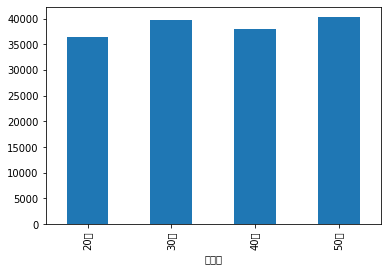

In [ ]:
age_total = user_total[(user_total['나이대'] == '20대') |
           (user_total['나이대'] == '30대') |
           (user_total['나이대'] == '40대') |
           (user_total['나이대'] == '50대') ]

age_total.groupby(['나이대'])['click_cnt'].mean()
age_total.groupby(['나이대'])['cart_cnt'].mean()
age_total.groupby(['나이대'])['like_cnt'].mean()
age_total.groupby(['나이대'])['buy_cnt'].mean()
age_total.groupby(['나이대'])['price'].mean()
age_total.groupby(['나이대'])['item_per_price'].mean().plot.bar()

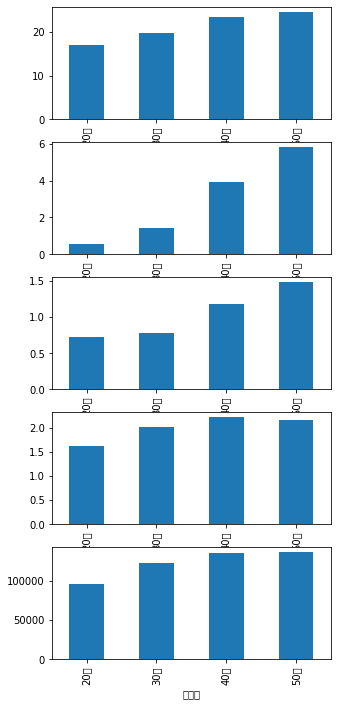

In [ ]:
f,ax = plt.subplots(5,1, figsize=(5,12))
age_total.groupby(['나이대'])['click_cnt'].mean().plot.bar(ax=ax[0])
age_total.groupby(['나이대'])['cart_cnt'].mean().plot.bar(ax=ax[1])
age_total.groupby(['나이대'])['like_cnt'].mean().plot.bar(ax=ax[2])
age_total.groupby(['나이대'])['buy_cnt'].mean().plot.bar(ax=ax[3])
age_total.groupby(['나이대'])['price'].mean().plot.bar(ax=ax[4])